# Load and show image

In [85]:
import glob
from PIL import Image
import os
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
import shutil

In [86]:
def plotImages(imgs, size=(3, 4), labels = []):
    
    # Number of rows and columns for the grid
    rows, cols = size

    # Create a figure and axes for the grid of images
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    # Flatten the 2D array of axes into a 1D array for easier indexing
    axes = axes.flatten()

    # Select 12 images to display (adjust this as needed)
    # image_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    image_indices = [element for element in range(rows * cols)]

    # Loop through the selected images and display them in the grid
    for i, image_index in enumerate(image_indices):
        if i < len(axes):
            # Get the image from the list
            image = imgs[image_index]

            # Display the image on the current axis
            axes[i].imshow(image)
            axes[i].axis('off')  # Turn off axis labels and ticks
            if len(labels) > i:
                class_title = labels[i]
                axes[i].set_title(f'{class_title}')

    # Remove any empty subplots (if there are fewer than 12 images)
    for i in range(len(image_indices), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [2]:
# Define the directory where your images are located
data_directory = "directory_path"  # Change this to your dataset directory

# Initialize an empty list to store the loaded images
image_list = []

# Define the file extensions for images you want to load
image_extensions = ["*.jpg", "*.jpeg", "*.png"]  # Add more extensions if needed
# Loop through each file extension and use glob to find matching image files
for extension in image_extensions:
    # Use glob to get a list of image files with the current extension
    image_files = glob.glob(os.path.join(data_directory, "**", extension), recursive=True)
    print("Total images for {} are {}".format(extension, len(image_files)))
    # Loop through the image files and load them using PIL (Pillow)
    for image_file in image_files:
        image = Image.open(image_file)
        # Append the loaded image to the list
        image_list.append(image.copy())
        image.close()

        
print("List Length: ", len(image_list))
image_list

## Showing original images

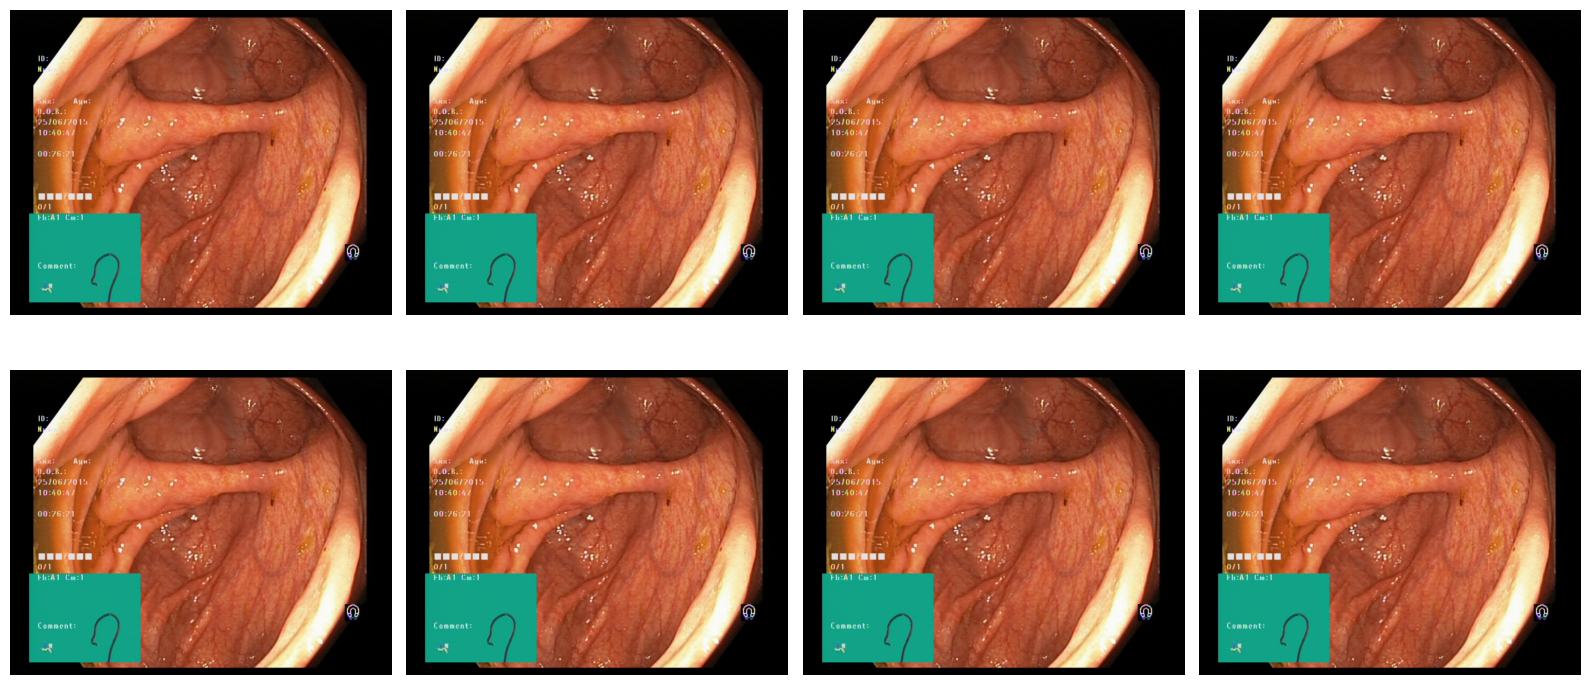

In [49]:
plotImages(images + [org_img], size=(2, 4))

In [50]:
for i, image_file in enumerate(image_files):
    image = Image.open(image_file)
    # Append the loaded image to the list
    images[i] = (image)

## Augmentation

In [51]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.9, aug)

seq = iaa.Sequential([
    
    #
    # Execute 0 to 5 of the following (less important) augmenters per
    # image. Don't execute all of them, as that would often be way too
    # strong.
    #
    iaa.SomeOf((0, 5), 
    [

        sometimes(
        iaa.Crop(percent=(0, 0.2)) # crop and pad images
        ),
        sometimes(
        iaa.Crop(px=(0, 16)) # crop images from each side by 0 to 16px (randomly chosen)
        ),
        sometimes(
        iaa.Fliplr(0.2) # horizontally flip 50% of the images
        ),
        sometimes(
        iaa.Flipud(0.2) # vertically flip 20% of all images
        ),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        sometimes(
        iaa.Multiply((0.8, 1.2), per_channel=0.2)
        ),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        sometimes(
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )),
        # Sharpen each image, overlay the result with the original
        # image using an alpha between 0 (no sharpening) and 1
        # (full sharpening effect).
        sometimes(
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))
        ),
        # Convert each image to grayscale and then overlay the
        # result with the original with random alpha. I.e. remove
        # colors with varying strengths.
        sometimes(
        iaa.Grayscale(alpha=(0.0, 1.0))
        ),
    ])


], random_order=True)


# image_array = np.array([np.array(image) for image in image_list])

# images_aug = seq(images=image_array)
labels = ["Orignal Image", "Crop & Pad", "Crop All Sides", "Horizontal Flip", "Multiply", "Scale, Rotate, Shear", "Sharpen", "Gray Scale"]
images = [0] * len(image_list)

In [52]:
#crop image
seq = iaa.Sequential([iaa.Crop(percent=(0, 0.2))])
images[0] = seq(image=np.array(image_list[0]))

In [53]:
#crop image
seq = iaa.Sequential([iaa.Crop(px=(0, 16))])
images[1] = seq(image=np.array(image_list[1]))

In [54]:
seq = iaa.Sequential([iaa.Fliplr(1)])
images[2] = seq(image=np.array(image_list[2]))

In [55]:
seq = iaa.Sequential([iaa.Multiply((0.9, 1.4), per_channel=0.2)])
images[3] = seq(image=np.array(image_list[3]))

In [56]:
seq = iaa.Sequential([iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )])
images[4] = seq(image=np.array(image_list[4]))

In [57]:
seq = iaa.Sequential([iaa.Sharpen(alpha=(0, 0.8), lightness=(0.75, 1.5))])
images[5] = seq(image=np.array(image_list[5]))

In [58]:
seq = iaa.Sequential([iaa.Grayscale(alpha=(0.0, 0.85))])
images[6] = seq(image=np.array(image_list[6]))

## Showing augmented images

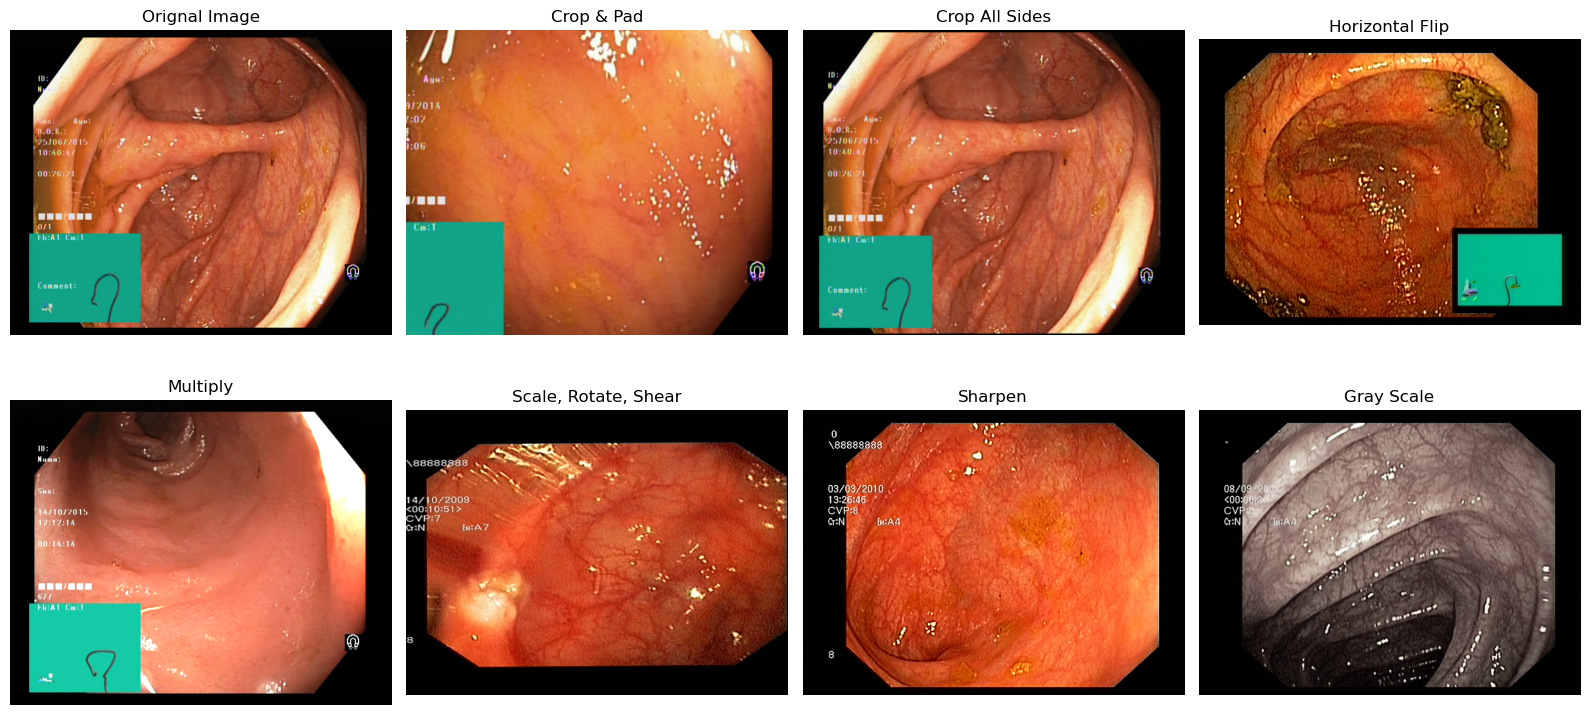

In [59]:
plotImages([org_img] + images, size=(2, 4), labels= labels)

## EDA: plot width and height in a graph

In [91]:
import os
from glob import glob
import numpy as np
import pandas as pd
# from bq_helper import BigQueryHelper
from dask import bag, diagnostics 
from urllib import request
import cv2
import missingno as msno
import hvplot.pandas  # custom install
from matplotlib import pyplot as plt
%matplotlib inline

In [109]:
dim_df = pd.DataFrame(dims, columns=['width', 'height'])
sizes = dim_df.groupby(['width', 'height']).size().reset_index().rename(columns={0:'count'})
sizes

,width,height,count
0,720,576,1556
1,768,576,2344
2,1232,1048,4
3,1280,1024,578
4,1350,1064,37
5,1350,1080,38
6,1920,1072,200


In [110]:
sizes.hvplot.scatter(x='width', y='height', size='count', xlim=(700,2000), ylim=(700,2000), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

:Scatter   [width]   (height,count)

In [113]:
from hvplot.plotting import scatter_matrix
scatter_matrix(sizes)

:GridMatrix   [X,Y]
   :Histogram   [width]   (width_count)

In [ ]:
sizes.hvplot.kde(['width','height', 'count'], by='count', alpha=0.5)